# **Import Necessary Libraries**
Commonly used libraries are imported here. Libraries for models may be imported when they will be used in their cell.

In [1]:
import sys
import os
import re
import json

import pandas as pd
import numpy as np

from collections import defaultdict
from tqdm import tqdm

# !pip install logparser
# from logparser import Spell, Drain

!pip install logpai
from logparser.Drain import Drain
from logparser.Spell import Spell

!pip install loglizer
from loglizer.models import PCA, IsolationForest, LogClustering
from loglizer import dataloader, preprocessing
from loglizer.utils import metrics

  Obtaining dependency information for logpai from https://files.pythonhosted.org/packages/31/9f/0f1f56a75acb188bf7747ca0692eb228fa40779be07e06f8dbeee84ac5b5/logpai-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for regex==2022.3.2 from https://files.pythonhosted.org/packages/70/f8/01e020980159de6b86092f00aa3965dae337c02b382750a605e324baad26/regex-2022.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.2/764.2 kB 25.6 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2023.8.8
    Uninstalling regex-2023.8.8:
      Successfully uninstalled regex-2023.8.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you ha

# **Load Dataset**

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/loghub-hadoop-distributed-file-system-log-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS.npz
/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_2/hadoop-hdfs-datanode-mesos-03.log
/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_2/hadoop-hdfs-datanode-mesos-02.log
/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_2/hadoop-hdfs-datanode-mesos-29.log
/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_2/hadoop-hdfs-datanode-mesos-22.log
/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_2/hadoop-hdfs-datanode-mesos-15.log
/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_2/hadoop-hdfs-datanode-mesos-07.log
/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_2/hadoop-hdfs-datanode-mesos-18.log
/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_2/hadoop-hdfs-datanode-mesos-16.log
/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_2/hadoop-hdfs-datanode-mesos-31.log
/kaggle/inpu

# **I/O locations and Files**

In [3]:
%%time

input_dir  = os.path.expanduser('/kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_1/')
output_dir = '/kaggle/working/hdfs/'
log_file   = "HDFS.log"
label_file = "anomaly_label.csv"

log_structured_file = output_dir + log_file + "_structured.csv"
log_templates_file = output_dir + log_file + "_templates.csv"
log_sequence_file = output_dir + "hdfs_sequence.csv"

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 16 µs


# **Parsing**

In [4]:
%%time

def parser(input_dir, output_dir, log_file, log_format, type='drain'):
    
    if type == 'spell':
        tau        = 0.5
        regex      = [
            "(/[-\w]+)+",
            "(?<=blk_)[-\d]+" 
        ]  

        parser = Spell.LogParser(indir=input_dir, outdir=output_dir, log_format=log_format, tau=tau, rex=regex, keep_para=False)
        parser.parse(log_file)

    elif type == 'drain':
        regex = [
            r"(?<=blk_)[-\d]+", #Block Id
            r'\d+\.\d+\.\d+\.\d+', #IP
            r"(/[-\w]+)+",  #File Path
        ]
        st = 0.5  # Similarity threshold
        depth = 5  # Depth of all leaf nodes

        parser = Drain.LogParser(log_format, indir=input_dir, outdir=output_dir, depth=depth, st=st, rex=regex, keep_para=False)
        parser.parse(log_file)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


In [5]:
%%time

log_format = '<Date> <Time> <Pid> <Level> <Component>: <Content>'
parser(input_dir, output_dir, log_file, log_format, 'drain')

Parsing file: /kaggle/input/loghub-hadoop-distributed-file-system-log-data/HDFS_1/HDFS.log
Total lines:  11175629
Processed 0.0% of log lines.
Processed 0.0% of log lines.
Processed 0.0% of log lines.
Processed 0.0% of log lines.
Processed 0.0% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.1% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.2% of log lines.
Processed 0.3% of log lines.
Processed 0.3% of log lines.
Processed 0.3% of log lines.
Processed 0.3% o

# **Maping**

In [6]:
%%time

def mapping():
    log_temp = pd.read_csv(log_templates_file)
    log_temp.sort_values(by = ["Occurrences"], ascending=False, inplace=True)
    log_temp_dict = {event: idx+1 for idx , event in enumerate(list(log_temp["EventId"])) }
    print(log_temp_dict)
    with open (output_dir + "hdfs_log_templates.json", "w") as f:
        json.dump(log_temp_dict, f)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 14.3 µs


In [7]:
%%time
mapping()

{'9b7aa7a3': 1, '2f313c72': 2, '2e1cf0aa': 3, '797b9c47': 4, 'b0023896': 5, 'bb837bbd': 6, '81358cb3': 7, '6caae5bd': 8, 'be6f070c': 9, 'd23206c6': 10, 'fa05ffa7': 11, '53c00e5f': 12, 'd7507d1e': 13, '0d168c98': 14, 'cf9b33dc': 15, 'd6115493': 16, '46f6e99a': 17, 'b46e298a': 18, 'fac2c191': 19, '4ed2a0c0': 20, '5e47c5c3': 21, '1995da3b': 22, '1d48c538': 23, 'b3ef6470': 24, 'ceedf750': 25, 'caed8b80': 26, '6f83a284': 27, '5832ad42': 28, 'c859931b': 29, '5ac8245b': 30, '190eb501': 31, 'f8ba9329': 32, '47b367ea': 33, '1ff93be5': 34, '72988c9b': 35, '78ad37b3': 36, 'ffa3fe68': 37, '60600882': 38, 'b55f27b2': 39, '9111794a': 40, 'ebe1d2fb': 41, 'a26fadbc': 42, 'f52097f4': 43, '0d527039': 44, '17ee882d': 45, 'fb314c6d': 46, '0555f7e9': 47}
CPU times: user 7.96 ms, sys: 3 ms, total: 11 ms
Wall time: 10.4 ms


# **Train Test Split**

In [33]:
%%time

(x_train, y_train), (x_test, y_test) = dataloader.load_HDFS(log_file=log_structured_file, label_file = input_dir + label_file)
# result = dataloader.load_HDFS(log_file=log_structured_file, label_file = input_dir + label_file)
# print(len(result))

====== Input data summary ======
Loading /kaggle/working/hdfs/HDFS.log_structured.csv
10170 6668
Total: 575061 instances, 16838 anomaly, 558223 normal
Train: 287530 instances, 10170 anomaly, 277360 normal
Test: 287531 instances, 6668 anomaly, 280863 normal

CPU times: user 16min 12s, sys: 9.87 s, total: 16min 22s
Wall time: 16min 23s


# **Feature Extraction**

In [37]:
import joblib

# After feature extraction
feature_extractor = preprocessing.FeatureExtractor()
x_train = feature_extractor.fit_transform(x_train)
x_test = feature_extractor.transform(x_test)

# Save the FeatureExtractor
joblib.dump(feature_extractor, 'feature_extractor.joblib')
print("Feature extractor saved successfully.")


====== Transformed train data summary ======
Train data shape: 287530-by-30

====== Transformed test data summary ======
Test data shape: 287531-by-30

Feature extractor saved successfully.


# **Models**

In [38]:
# Import necessary modules
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the LSTM Network
def lstm_network(input_shape):
    x_input = Input(shape=input_shape)
    x = LSTM(64, activation='relu', return_sequences=True, name='lstm_1')(x_input)
    x = LSTM(64, activation='relu', name='lstm_2')(x)
    x = Dense(29, activation='relu')(x)
    classification = Dense(1, activation='sigmoid')(x)
    return Model(inputs=x_input, outputs=classification)

# Assuming x_train, y_train, x_test, y_test are your datasets and are numpy arrays
# LSTM networks expect input data in a 3D shape: (samples, timesteps, features)

# Reshape data
timesteps = 1  # Set timesteps to 1 if your data isn't sequential
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], timesteps, x_train.shape[1]))
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], timesteps, x_test.shape[1]))

# Build and compile the LSTM Network
input_shape = (timesteps, x_train.shape[1])
model = lstm_network(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    x_train_reshaped,
    y_train,
    epochs=10,
    batch_size=32
)

# Save the model
model.save('my_lstm_model_final.h5')  # Changed from 'my_lstm_model.keras' to 'my_lstm_model.h5'
print("Model saved successfully.")

# Evaluate on training data
train_predictions = model.predict(x_train_reshaped)
train_classification_preds = (train_predictions > 0.5).astype(int)

train_precision = precision_score(y_train, train_classification_preds)
train_recall = recall_score(y_train, train_classification_preds)
train_f1 = f1_score(y_train, train_classification_preds)
print('Train validation:')
print(f'Precision: {train_precision}, Recall: {train_recall}, F1-score: {train_f1}')

# Evaluate on test data
test_predictions = model.predict(x_test_reshaped)
test_classification_preds = (test_predictions > 0.5).astype(int)

test_precision = precision_score(y_test, test_classification_preds)
test_recall = recall_score(y_test, test_classification_preds)
test_f1 = f1_score(y_test, test_classification_preds)
print('Test validation:')
print(f'Precision: {test_precision}, Recall: {test_recall}, F1-score: {test_f1}')


Epoch 1/10
8986/8986 [==============================] - 45s 5ms/step - loss: 0.0565 - accuracy: 0.9866
Epoch 2/10
8986/8986 [==============================] - 41s 5ms/step - loss: 0.0446 - accuracy: 0.9884
Epoch 3/10
8986/8986 [==============================] - 49s 5ms/step - loss: 0.0417 - accuracy: 0.9890
Epoch 4/10
8986/8986 [==============================] - 42s 5ms/step - loss: 0.0400 - accuracy: 0.9893
Epoch 5/10
8986/8986 [==============================] - 42s 5ms/step - loss: 0.0386 - accuracy: 0.9897
Epoch 6/10
8986/8986 [==============================] - 41s 5ms/step - loss: 0.0382 - accuracy: 0.9897
Epoch 7/10
8986/8986 [==============================] - 44s 5ms/step - loss: 0.0376 - accuracy: 0.9898
Epoch 8/10
8986/8986 [==============================] - 43s 5ms/step - loss: 0.0374 - accuracy: 0.9898
Epoch 9/10
8986/8986 [==============================] - 41s 5ms/step - loss: 0.0370 - accuracy: 0.9899
Epoch 10/10
8986/8986 [==============================] - 42s 5ms/step - l

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8986/8986 [==============================] - 22s 2ms/step
Train validation:
Precision: 0.9908380490433846, Recall: 0.7231071779744346, F1-score: 0.83606184629377
8986/8986 [==============================] - 22s 2ms/step
Test validation:
Precision: 0.7675582066576871, Recall: 0.5982303539292142, F1-score: 0.6723978086809945


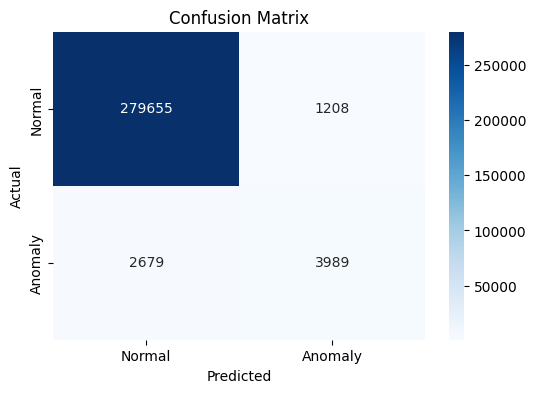

In [39]:
# Import necessary modules
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, test_classification_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [19]:
model.save('my_lstm_model.keras')

In [20]:
import tensorflow as tf
print("TensorFlow Version (Training):", tf.__version__)


TensorFlow Version (Training): 2.13.0


In [ ]:
%%time

def mapping():
    log_temp = pd.read_csv(log_templates_file)
    log_temp.sort_values(by = ["Occurrences"], ascending=False, inplace=True)
    log_temp_dict = {event: idx+1 for idx , event in enumerate(list(log_temp["EventId"])) }
    print(log_temp_dict)
    with open (output_dir + "hdfs_log_templates.json", "w") as f:
        json.dump(log_temp_dict, f)
%%time
mapping()
%%time

(x_train, y_train), (x_test, y_test) = dataloader.load_HDFS(log_file=log_structured_file, label_file = input_dir + label_file)
# result = dataloader.load_HDFS(log_file=log_structured_file, label_file = input_dir + label_file)
# print(len(result))

feature_extractor = preprocessing.FeatureExtractor()
x_train = feature_extractor.fit_transform(x_train)
x_test = feature_extractor.transform(x_test)

# Import necessary modules
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the LSTM Network
def lstm_network(input_shape):
    x_input = Input(shape=input_shape)
    x = LSTM(64, activation='relu', return_sequences=True)(x_input)
    x = LSTM(64, activation='relu')(x)
    x = Dense(29, activation='relu')(x)
    classification = Dense(1, activation='sigmoid')(x)
    return Model(inputs=x_input, outputs=classification)

# Assuming x_train, y_train, x_test, y_test are your datasets and are numpy arrays
# LSTM networks expect input data in a 3D shape: (samples, timesteps, features)

# Reshape data
timesteps = 1  # Set timesteps to 1 if your data isn't sequential
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], timesteps, x_train.shape[1]))
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], timesteps, x_test.shape[1]))

# Build and compile the LSTM Network
input_shape = (timesteps, x_train.shape[1])
model = lstm_network(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    x_train_reshaped,
    y_train,
    epochs=10,
    batch_size=32
)

# Evaluate on training data
train_predictions = model.predict(x_train_reshaped)
train_classification_preds = (train_predictions > 0.5).astype(int)

train_precision = precision_score(y_train, train_classification_preds)
train_recall = recall_score(y_train, train_classification_preds)
train_f1 = f1_score(y_train, train_classification_preds)
print('Train validation:')
print(f'Precision: {train_precision}, Recall: {train_recall}, F1-score: {train_f1}')

# Evaluate on test data
test_predictions = model.predict(x_test_reshaped)
test_classification_preds = (test_predictions > 0.5).astype(int)

test_precision = precision_score(y_test, test_classification_preds)
test_recall = recall_score(y_test, test_classification_preds)
test_f1 = f1_score(y_test, test_classification_preds)
print('Test validation:')
print(f'Precision: {test_precision}, Recall: {test_recall}, F1-score: {test_f1}')

# Import necessary modules
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, test_classification_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

model.save('my_lstm_model.keras')